# Simulating some genomes

We'll simulate some "human" genomes using the [stdpopsim](https://stdpopsim.readthedocs.io/en/latest/) package,
and manipulate the tree sequences with the tree sequence toolkit [tskit](https://tskit.readthedocs.io/en/latest/).

In [1]:
# these can be installed with
#   pip install tskit msprime stdpopsim
import tskit, stdpopsim
from IPython.display import SVG, display, clear_output, Image
import time
import numpy as np

Following one of stdpopsim's [tutorials](https://stdpopsim.readthedocs.io/en/latest/tutorial.html#running-stdpopsim-with-the-python-interface-api),
let's simulate 30 copies of human chromosome 22,
ten each sampled today from the three geographic regions:
"Africa" (AFR), "Northern Europe" (CEU) and "East Asian" (CHB),
following the simplified "out of Africa" demographic model
of [Gutenkunst et al 2009](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000695).

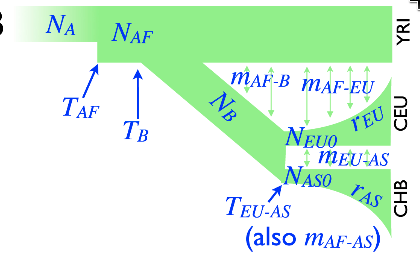

In [2]:
Image("figs/gutenkunst_2009.png")

In [3]:
species = stdpopsim.get_species("HomSap")
contig = species.get_contig("chr22")
model = species.get_demographic_model('OutOfAfrica_3G09')
samples = model.get_samples(10, 10, 10)
engine = stdpopsim.get_engine('msprime')

This next step - the simulation - takes some time, but only a few minutes.

In [4]:
ts = engine.simulate(model, contig, samples)

Great! Now let's look at what we have:

In [5]:
print(f"The tree sequence contains {ts.num_trees} trees describing relationships between "
      f"{ts.num_nodes} nodes along a genome of length {int(ts.sequence_length)}bp, "
      f"along which there are mutations at {ts.num_sites} sites.")

The tree sequence contains 90165 trees describing relationships between 54514 nodes along a genome of length 51304566bp, along which there are mutations at 95532 sites.


In [6]:
g = ts.genotype_matrix()
g[:, :10]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 0, 0]], dtype=int8)

Now, some magic to be able to make pretty pictures of the trees:

In [7]:
tables = ts.tables
tables.populations.metadata_schema = tskit.MetadataSchema({'type': 'object', 'codec': 'json', 'properties': {'id': {'type': 'string'}, 'id': {'type': 'string'}, 'sampling_time': {'type': 'integer'}}})
ts = tables.tree_sequence()

In [8]:
def color_edges(t):
    style = ""
    pop_colors = {'YRI': 'red', 'CEU': 'blue', 'CHB': 'green'}
    for n in t.nodes():
        nn = list(t.samples(n))
        pops = ts.tables.nodes.population[nn]
        if len(set(pops)) == 1:
            col = pop_colors[ts.population(pops[0]).metadata['id']]
            style += f" .tree .n{n} .edge {{stroke: {col} }} "
    return style

And, here's the first tree (i.e., the one at the left edge of the chromosome).
There are two mutations on it, both inherited by about half the African and European genomes,
and one of the Asian genomes.

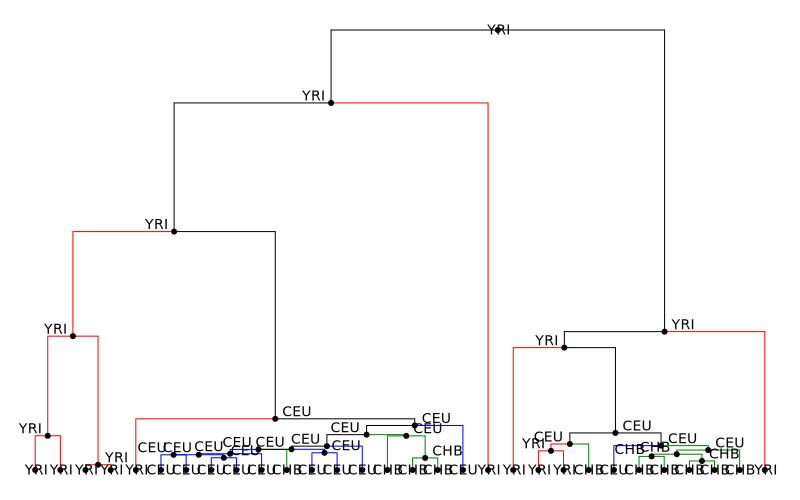

In [9]:
t = ts.first()
fig = SVG(t.draw_svg(root_svg_attributes={"id": "first"}, size=(800,500), # max_tree_height="ts",
               node_labels = {n.id : ts.population(n.population).metadata['id'] for n in ts.nodes()},
               style="first.tree .edge {stroke-width: 3pt}" + color_edges(t) +
                     "first.tree .node:not(.sample) > text {visibility: hidden}"
                     "first.tree .node.leaf > text { transform: translateY(0.5em) rotate(90deg); text-anchor: start}"))
display(fig)

The trees vary quite a bit in height - at a few places on the genome,
everyone's common ancestor lived quite a long time ago.
Here's the sequence of trees leading up to one of those places:

In [10]:
max_node = np.argmax(ts.tables.nodes.time)
left, right = (
        np.min(ts.tables.edges.left[ts.tables.edges.parent == max_node]),
        np.max(ts.tables.edges.right[ts.tables.edges.parent == max_node])
    )
left, right

(29675522.878441665, 29676105.159226842)

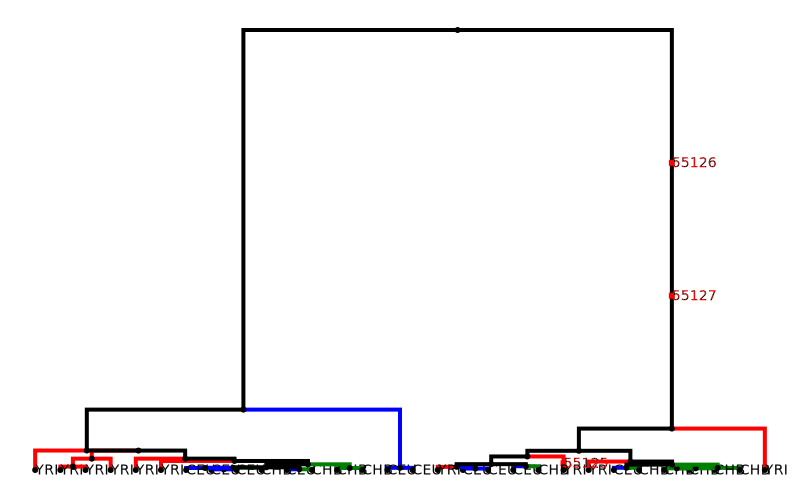

In [11]:
for t in ts.trees():
    if t.interval[1] > right:
        break
    if t.interval[0] > left - 3e3:
        fig = SVG(t.draw_svg(root_svg_attributes={"id": "first"}, size=(800,500), max_tree_height="ts",
                   node_labels = {n.id : ts.population(n.population).metadata['id'] for n in ts.nodes()},
                   style=".tree .edge {stroke-width: 3pt}" + color_edges(t) +
                         ".tree .node:not(.sample) > text {visibility: hidden}"
                         ".tree .node.leaf > text { transform: translateY(0.5em) rotate(90deg); text-anchor: start}"))
        clear_output(wait=True)
        display(fig)
